In [5]:
from abc import ABC, abstractmethod
import struct
import datetime
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog


class ParserInterface(ABC):
    @abstractmethod
    def parse(self, file_path, filter_field=None, filter_value=None):
        pass

def select_file():
        # 创建Tkinter根窗口
        root = tk.Tk()
        root.withdraw()  # 隐藏根窗口

        # 打开文件选择对话框
        file_path = filedialog.askopenfilename()
        return file_path

class ParserInterface(ABC):
    @abstractmethod
    def parse(self, file_path, filter_field=None, filter_value=None):
        pass

class ChartNormalParser(ParserInterface):
    def __init__(self, format_string='<BHHIHHh'):
        self.format_string = format_string
        self.data_size = struct.calcsize(format_string)
        self.data_sets = []
        self.heart_rate = {'max': 0, 'min': 1000, 'sum':0, 'count':0, 'avg': 0}

    def parse(self, file_path, filter_field=None, filter_value=None):
        self.read_binary_file(file_path, filter_field, filter_value)
        self.plot_rtc_times()
    
    def heart_rate_stats(self, heart_rate):
        if heart_rate == 0:
            return
        if heart_rate > self.heart_rate['max']:
            self.heart_rate['max'] = heart_rate
        if heart_rate < self.heart_rate['min']:
            self.heart_rate['min'] = heart_rate
        
        self.heart_rate['sum'] += heart_rate
        self.heart_rate['count'] += 1
        self.heart_rate['avg'] = self.heart_rate['sum'] / self.heart_rate['count']


    def read_binary_file(self, file_path, filter_field=None, filter_value=None):
        with open(file_path, 'rb') as file:
            while True:
                data = file.read(self.data_size)
                if not data:
                    break
                parsed_data = struct.unpack(self.format_string, data)
                if filter_field and filter_value is not None:
                    if not self.apply_filter(parsed_data, filter_field, filter_value):
                        continue
                # self.print_parsed_data(parsed_data)
                self.data_sets.append(parsed_data)
                self.heart_rate_stats(parsed_data[2])
            
            print(f"Heart Rate Info: Max: {self.heart_rate['max']}, Min: {self.heart_rate['min']}, Avg: {self.heart_rate['avg']}")

    def apply_filter(self, parsed_data, filter_field, filter_value):
        fields = ['version', 'tag', 'heart_rate', 'rtc_time', 'average_speed', 'step_freq', 'altitude']
        field_index = fields.index(filter_field)
        return parsed_data[field_index] == filter_value

    def print_parsed_data(self, parsed_data):
        version, tag, heart_rate, rtc_time, average_speed, step_freq, altitude = parsed_data
        readable_time = datetime.datetime.fromtimestamp(rtc_time).strftime('%Y-%m-%d %H:%M:%S')
        print(f"Version: {version}")
        print(f"Tag: {tag}")
        print(f"Heart Rate: {heart_rate} counts/minute")
        print(f"RTC Time: {rtc_time} ({readable_time})")
        print(f"Average Speed: {average_speed} seconds/hundred meter")
        print(f"Step Frequency: {step_freq}")
        print(f"Altitude: {altitude} meters")
        print("-" * 40)  # 分隔线

    def plot_rtc_times(self, field_in=None):
        fields = ['version', 'tag', 'heart_rate', 'rtc_time', 'average_speed', 'step_freq', 'altitude']
        
        # Create subplots for each field
        fig, axes = plt.subplots(len(fields), 1, figsize=(10, 5*len(fields)))
        
        for idx, field in enumerate(fields):
            y_datas = [data[idx] for data in self.data_sets]
            axes[idx].plot(range(len(y_datas)), y_datas, linestyle='-')
            axes[idx].set_xlabel('Index')
            axes[idx].set_ylabel(field)
            axes[idx].set_title(f"{field} vs. Index")
            axes[idx].grid(True)
        
        plt.tight_layout()
        plt.show()

class GPSParser(ParserInterface):
    VERSION_5 = 5
    def __init__(self):
        # Format string for struct: B=uint8, H=uint16, I=uint32, d=double, f=float
        self.format_string = '<BHBIffffIBI'
        self.old_format_string = '<BHBIddffI'
        self.version_string= '<B'
        self.data_size = struct.calcsize(self.format_string)
        self.version_size = struct.calcsize(self.version_string)
        self.old_data_size = struct.calcsize(self.old_format_string)
        self.data_sets = []
        
    def parse(self, file_path, filter_field=None, filter_value=None):
        self.read_binary_file(file_path, filter_field, filter_value)
        self.plot_gps_data()
        
    def read_binary_file(self, file_path, filter_field=None, filter_value=None):
        with open(file_path, 'rb') as file:
            version_data = file.read(self.version_size)

            if not version_data:
                return

            parsed_version = struct.unpack(self.version_string, version_data)[0]

            print(f"Version: {parsed_version}")

            if parsed_version >= self.VERSION_5:
                self.proper_size = struct.calcsize(self.format_string)
                self.proper_format = self.format_string
            else:
                self.proper_size = struct.calcsize(self.old_format_string)
                self.proper_format = self.old_format_string

            print(f"Proper size: {self.proper_size}, Proper format: {self.proper_format}")
            
            file.seek(0)

            while True:
                data = file.read(self.proper_size)

                if not data:
                    break

                parsed_data = struct.unpack(self.proper_format, data)
                if filter_field and filter_value is not None:
                    if not self.apply_filter(parsed_data, filter_field, filter_value):
                        continue
           
                self.print_parsed_data(parsed_data)
                self.data_sets.append(parsed_data)
                
    def apply_filter(self, parsed_data, filter_field, filter_value):
        fields = ['version', 'id', 'status', 'timestamp', 'longitude', 
                 'latitude', 'speed', 'distance', 'calorie', 'gps_source', 'gps_qos']
        field_index = fields.index(filter_field)
        return parsed_data[field_index] == filter_value
        
    def print_parsed_data(self, parsed_data):
        version, id_, status, timestamp, longitude, latitude, speed, distance, calorie, gps_source, gps_qos = parsed_data
        readable_time = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        print(f"Version: {version}")
        print(f"ID: {id_}")
        print(f"Status: {status}")
        print(f"Timestamp: {timestamp} ({readable_time})")
        print(f"Location: {latitude:.6f}°N, {longitude:.6f}°E")
        print(f"Speed: {speed:.2f} m/s")
        print(f"Distance: {distance:.2f} m")
        print(f"Calorie: {calorie}")
        print(f"GPS Source: {'Phone' if gps_source else 'Watch'}")
        print(f"GPS QoS - Satellites: {gps_qos & 0xFF}, CN0: {(gps_qos >> 8) & 0xFF}, Quality: {(gps_qos >> 16) & 0xFF}")
        print("-" * 40)
        
    def plot_gps_data(self):
        if not self.data_sets:
            print("No data to plot")
            return
            
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Extract data
        timestamps = [data[3] for data in self.data_sets]
        times = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
        longitudes = [data[4] for data in self.data_sets]
        latitudes = [data[5] for data in self.data_sets]
        speeds = [data[6] for data in self.data_sets]
        distances = [data[7] for data in self.data_sets]
        
        # Plot GPS track
        ax1.plot(longitudes, latitudes, 'b-')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title('GPS Track')
        ax1.grid(True)
        
        # Plot speed over time
        ax2.plot(times, speeds, 'g-')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Speed (m/s)')
        ax2.set_title('Speed vs Time')
        ax2.grid(True)
        
        # Plot distance over time
        ax3.plot(times, distances, 'r-')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Distance (m)')
        ax3.set_title('Distance vs Time')
        ax3.grid(True)
        
        # Plot altitude profile if available
        if self.data_sets[0][10]:  # Check if QoS data exists
            satellites = [data[10] & 0xFF for data in self.data_sets]
            ax4.plot(times, satellites, 'y-')
            ax4.set_xlabel('Time')
            ax4.set_ylabel('Satellite Count')
            ax4.set_title('Satellite Count vs Time')
            ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

class SummaryParser(ParserInterface):
    def __init__(self):
        self.format_string = "<BHHIIIIIIBBBIIHHHHIIIIIIIHHHHHHHBHHHIIIHHHIIIfIIIIIIIIIIIfIIIBBBBBBfffBIBIBIIIIIIIIiiiiIIIIIII"

        self.data_sets = []

    def parse(self, file_path, filter_field=None, filter_value=None):
        self.read_binary_file(file_path, filter_field, filter_value)
    
    def read_binary_file(self, file_path, filter_field=None, filter_value=None):
        s = struct.calcsize(self.format_string)
        print(f"Size: {s}")
        with open(file_path, 'rb') as file:
            while True:
                data = file.read(struct.calcsize(self.format_string))
                if not data:
                    break
                parsed_data = struct.unpack(self.format_string, data)
                self.print_parsed_data(parsed_data)

    def print_parsed_data(self, parsed_data):
        print(parsed_data)    

    

class ReportParser(ParserInterface):
    TYPE_REPORT = 0
    TYPE_GPS = 2
    TYPE_SUMMARY = 3
    HEADER_SIZE = 6
    def __init__(self) -> None:
        super().__init__()
    
    def parse_header(self, buffer):
        print(f"Buufer size: {struct.calcsize('<BBI')}")
        version, type_, size = struct.unpack('<BBI', buffer)

        header = {
            'version': version,
            'type': type_,
            'size': size
        }

        return header
        
    def parse(self, file_path, filter_field=None, filter_value=None):
        """
        Parse bytes from a file with optional filtering
        Args:
            file_path: Path to file to parse
            filter_field: Optional field name to filter on
            filter_value: Optional value to match against filter_field
        Returns:
            bytes: Parsed file contents
        """
        try:
            with open(file_path, 'rb') as f:
                while True:
                    header_buf = f.read(self.HEADER_SIZE)

                    if not header_buf:
                        break

                    header = self.parse_header(header_buf)
                    print(header)

                    content_buf = f.read(header['size'])

                    if header['type'] == self.TYPE_REPORT:
                        print(f"report_{header['type']}.txt")
                        with open(f"report_{header['type']}.txt", 'wb') as report_file:
                            report_file.write(content_buf)
                        
                        chart_parser = ChartNormalParser()
                        chart_parser.parse(f"report_{header['type']}.txt", filter_field, filter_value)
                        
                    if header['type'] == self.TYPE_GPS:
                        print(f"gps_{header['type']}.txt")
                        with open(f"gps_{header['type']}.txt", 'wb') as gps_file:
                            gps_file.write(content_buf)

                        gps_parser = GPSParser()
                        gps_parser.parse(f"gps_{header['type']}.txt", filter_field, filter_value)

                    if header['type' ] == self.TYPE_SUMMARY:
                        print(f"summary_{header['type']}.txt")
                        with open(f"summary_{header['type']}.txt", 'wb') as summary_file:
                            summary_file.write(content_buf)
                        
                        summary_parser = SummaryParser()
                        summary_parser.parse(f"summary_{header['type']}.txt", filter_field, filter_value)

        except IOError as e:
            raise IOError(f"Error reading file {file_path}: {str(e)}")

def parse_files(filter_field=None, filter_value=None):
    file_path = select_file()

    if file_path:
        # 检查文件名是否以"chart_normal"结尾
        if file_path.endswith("chart_normal"):
            parser = ChartNormalParser()
            parser.parse(file_path, filter_field, filter_value)
        else:
            print("Error: The selected file does not end with 'chart_normal'.")
    else:
        print("No file path selected")

Buufer size: 6
{'version': 2, 'type': 0, 'size': 8250}
report_0.txt
Heart Rate Info: Max: 200, Min: 135, Avg: 187.79266055045872


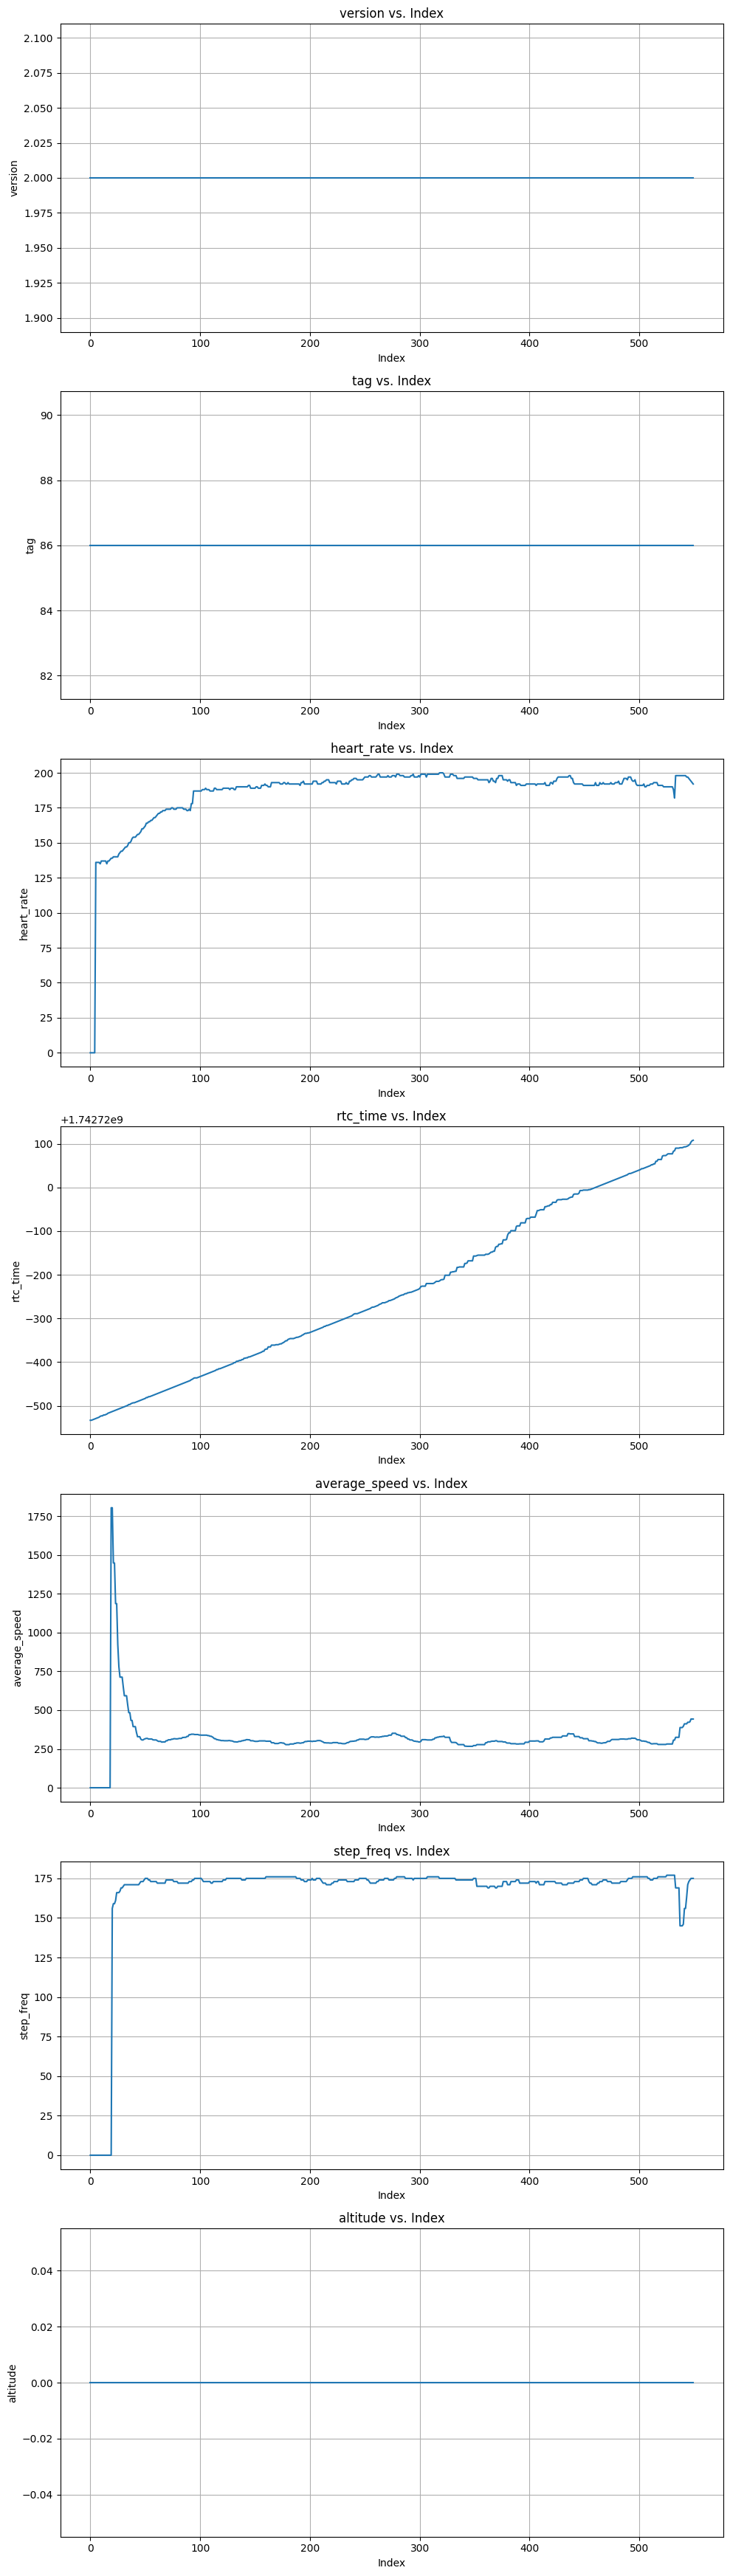

Buufer size: 6
{'version': 2, 'type': 3, 'size': 195}
summary_3.txt
Size: 296


error: unpack requires a buffer of 296 bytes

In [6]:
file_path = select_file()
rp = ReportParser()
rp.parse(file_path)